$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$

<div align=center>

# Quantum dynnamics and quantum control: Lattice spin system

</div>


$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$

---
# Initialization

In [1]:
# Check, install and import requirements and define utility functions.

import pkg_resources
from pkg_resources import DistributionNotFound, VersionConflict
import os
import time

dependencies = [
  'numpy',
  'matplotlib'
]

try:
    pkg_resources.require(dependencies)
except DistributionNotFound:
    os.system("pip install numpy")
    os.system("pip install matplotlib")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

from copy import deepcopy
from IPython.display import display as disp, Math, Latex

def as_latex_matrix(m, replace_zeros = "0", round=3, max_size=8):
  """Convert a matrix to a LaTeX matrix stored as a string."""
  m = np.array(m)

  Hcut = m.shape[0] > max_size
  Vcut = m.shape[1] > max_size
  if Hcut or Vcut:
    cut_at = int(np.ceil(max_size/2))
    a = np.empty(
      (min(m.shape[0], max_size), min(m.shape[1], max_size)), dtype=complex
    )

    if Hcut and Vcut:
      a[:cut_at, :cut_at] = m[:cut_at, :cut_at]
      a[:cut_at, -cut_at:] = m[:cut_at, -cut_at:]
      a[-cut_at:, :cut_at] = m[-cut_at:, :cut_at]
      a[-cut_at:, -cut_at:] = m[-cut_at:, -cut_at:]
    elif Hcut and not Vcut:
      a[:cut_at, :] = m[:cut_at, :]
      a[-cut_at:, :] = m[-cut_at:, :]
    elif Vcut and not Hcut:
      a[:, :cut_at] = m[:, :cut_at]
      a[:, -cut_at:] = m[:, -cut_at:]
    
    m = a

  def matrix_line(line, replace_zeros):
    line_elements = []
    for i, element in enumerate(line):
      if Hcut and i == cut_at:
        line_elements.append(r"\cdots")
      if (i := np.round(element, round)) != 0 or not replace_zeros:
        if np.imag(i) == 0:
          if int(np.real(i)) == np.real(i):
            i = int(np.real(i))
          else:
            i = np.real(i)
        line_elements.append(f"{i}")
      else:
        line_elements.append(str(replace_zeros))
    return " & ".join(line_elements)

  if len(m.shape) == 1:
    matrix = matrix_line(m, replace_zeros)
  else:
    matrix = []
    for i, line in enumerate(m):
      if Vcut and i == cut_at:
        matrix.append("&".join([r"\cdots"]*(m.shape[1]+1)))
      matrix.append(matrix_line(line, replace_zeros))   
    
    matrix = r"\\ ".join(matrix)
  
  return r"\begin{pmatrix}" + matrix + r"\end{pmatrix}"

def braket_notation(vector, separator="", round=3):
  """Convert a vector to a LaTeX ket notation."""
  vector = np.array(vector)
  vector = np.round(vector,round)

  N = vector.shape[0]
  n = int(np.sqrt(N))
  
  if vector.shape[0] == 1:
    vec = vector[0,:]
    state='';
    for i in range(N):
        if abs(vec[i])>10**(-6):
            state=state+'+'+str(vec[i])+r' \bra{'+format(i,'0'+str(n)+'b')+r'} '
  else:
    vec = vector[:,0]
    state=''
    for i in range(N):
        if abs(vec[i])>10**(-6):
            state=state+'+'+str(vec[i])+r' \ket{'+format(i,'0'+str(n)+'b')+r'} '
  return state

def scalar(m):
  """Convert a 1x1 matrix to a scalar."""
  return m.item()

def print_latex(code):
  """Print a LaTeX string."""
  disp(Math(code))

def as_array(vec):
  """Convert a vector to a numpy array."""
  return np.array(vec).reshape(max(vec.shape))

In [2]:
# Include base code (given in subject)

import numpy as np
import scipy as sp
from numpy import linalg as la
import matplotlib.pyplot as plt
from numpy import linalg as LA;
from scipy import linalg as LA2;
from numpy import random as rand
from scipy.sparse import diags

def tensorvect(a,b):
    return(np.tensordot(a,b,axes=0).flatten())

def tensorvectop(a,b):
    return LA2.kron(a,b)

def opchain(a,i,nspin):
    if i==1:
        return LA2.kron(a,np.identity(2**(nspin-1)))
    else:
        if i==nspin:
            return LA2.kron(np.identity(2**(nspin-1)),a)
        else:
            return LA2.kron(LA2.kron(np.identity(2**(i-1)),a),np.identity(2**(nspin-i)))
        
def opchain2(a,i,b,j,nspin):
    if i==1:
        if j==nspin:
            return LA2.kron(LA2.kron(a,np.identity(2**(nspin-2))),b)
        else:
            return LA2.kron(LA2.kron(a,np.identity(2**(j-2))),LA2.kron(b,np.identity(2**(nspin-j))))      
    else:
        if j==nspin:
            return LA2.kron(LA2.kron(np.identity(2**(i-1)),a),LA2.kron(np.identity(2**(nspin-(i+1))),b))
        else:
            return LA2.kron(LA2.kron(LA2.kron(np.identity(2**(i-1)),a),LA2.kron(np.identity(2**(j-(i+1))),b)),np.identity(2**(nspin-j)))
            
def buildstate(bin):
    v=[0. for i in range(2**len(bin))];
    v[int(bin,2)]=1.
    return np.array(v)


def diracrep(psi,nspin):
    state='';
    for i in range(2**nspin):
        if abs(psi[i])>10**(-6):
            state=state+'+'+str(psi[i])+'|'+format(i,'0'+str(nspin)+'b')+'>'
    return state

def binnum(n):
    l=['0','1'];
    if n==1:
        return l
    else:
        return ['0'+i for i in binnum(n-1)]+['1'+i for i in binnum(n-1)]
    
def densmat(psi,i,nspin):
    if i>1:
        listindex0=binnum(i-1)
        listindex0=[j+'0' for j in listindex0]
    else:
        listindex0=['0']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex0=list(np.array([[j+k for k in listcomp] for j in listindex0]).flatten())
    if i>1:
        listindex1=binnum(i-1)
        listindex1=[j+'1' for j in listindex1]
    else:
        listindex1=['1']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex1=list(np.array([[j+k for k in listcomp] for j in listindex1]).flatten())
    rho00=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex0)
    rho11=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex1)
    rho01=sum(psi[int(j,2)]*np.conjugate(psi[int(listindex1[listindex0.index(j)],2)]) for j in listindex0)
    return np.array([[rho00,rho01],[np.conjugate(rho01),rho11]])

def avdensmat(psi,nspin):
    rho=densmat(psi,1,nspin);
    if nspin>1:
        for i in range(2,nspin+1):
            rho=rho+densmat(psi,i,nspin)
    rho=rho/nspin;
    return rho

def purity(rho):
    rho2 = np.dot(rho,rho)
    tr = np.trace(rho2)
    return(tr)

def SvN(rho):
    vp=np.real(LA.eigvals(rho));
    S=0.;
    for i in range(len(vp)):
        if vp[i]>0.:
            S=S+vp[i]*np.log(vp[i])
    return -S

def entangl(psi,nspin):
    S=SvN(densmat(psi,1,nspin));
    if nspin>1:
        for i in range(2,nspin+1):
            S=S+SvN(densmat(psi,i,nspin))
    return S/nspin

def disorder(psi,nspin):
    return SvN(avdensmat(psi,nspin))-entangl(psi,nspin)

sigX=np.array([[0.,1.],[1.,0.]]);
sigY=np.array([[0.,-1j],[1j,0.]]);
sigZ=np.array([[1.,0.],[0.,-1.]]);
sig1=np.array([[1.,0.],[0.,0.]]);
id2 =np.array([[1.,0.],[0.,1.]]);

NOT=sigX;
HAD1=np.array([[1./np.sqrt(2.),1./np.sqrt(2.)],[1./np.sqrt(2.),-1./np.sqrt(2.)]]);
CNOT=np.array([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,0.,1.],[0.,0.,1.,0.]]);
HAD2=np.array([[0.5,0.5,0.5,0.5],[0.5,-0.5,0.5,-0.5],[0.5,0.5,-0.5,-0.5],[0.5,-0.5,-0.5,0.5]]);
SWAP=np.array([[1.,0.,0.,0.],[0.,0.,1.,0.],[0.,1.,0.,0.],[0.,0.,0.,1.]]);

---

# Basics

The following code will serve as a base of all this practical work.

## Spin chain builders

In [3]:
# Spin chains hamiltonians

def openedSpinChain(sig, N=8, w=0.5, J=1):
        h0 = -w * sig1
        H0 = sum([opchain(h0, i, N) for i in range(1, N + 1)])
        Hi = np.zeros(H0.shape, dtype=complex)
        for i in range(N - 1):
            Hi -= J * opchain2(.5 * sig, i + 1, .5 * sig, i + 2, N)

        return H0, Hi, H0 + Hi

def closedSpinChain(sig, N=8, w=0.5, J=1):
    H = openedSpinChain(sig, N, w, J)
    H -= J * opchain2(.5 * sig, 1, .5 * sig, N, N)
    return H

## Model definition

In [4]:
# Model class

class Model:

    def __init__(self, name, type, N=8, w=0.5, J=1):
        self.name = name
        self.N = N
        self.w = w

        # J -> [Jx, Jy, Jz]
        if isinstance(J, int) or isinstance(J, float):
            self.J = np.ones(3)*J
        elif hasattr(J, '__iter__') and len(J) == 3:
            self.J = np.array(J)
        else:
            raise ValueError("J must be a number or an iterable of length 3")
        
        self.H0, self.Hi, self.H = type(self)

    # ========== Model builders ==========    
    
    # ---------- Ising models ----------

    def openedIsing(self):
        H0, Hi, H = openedSpinChain(sigX, self.N, self.w, self.J[0])
        tmp1, tmp2, tmp3 = openedSpinChain(sigY, self.N, self.w, self.J[1])
        H0 += tmp1; Hi += tmp2; H += tmp3
        tmp1, tmp2, tmp3 = openedSpinChain(sigZ, self.N, self.w, self.J[2])
        return H0 + tmp1, Hi + tmp2, H + tmp3

    def closedIsing(self):
        H0, Hi, H = closedSpinChain(sigX, self.N, self.w, self.J[0])
        tmp1, tmp2, tmp3 = closedSpinChain(sigY, self.N, self.w, self.J[1])
        H0 += tmp1; Hi += tmp2; H += tmp3
        tmp1, tmp2, tmp3 = closedSpinChain(sigZ, self.N, self.w, self.J[2])
        return H0 + tmp1, Hi + tmp2, H + tmp3

    def randomIsingX(self):
        self.J = np.zeros(3)
        H0 = 0
        for i in range(self.N):
            w = np.random.uniform(0., .5)
            h0 = -w * sig1
            H0 += opchain(h0, i + 1, self.N)

        Hi = np.zeros(H0.shape, dtype=complex)
        for i in range(self.N - 1):
            J = np.random.uniform(-1, 1)
            Hi -= J * opchain2(.5 * sigX, i + 1, .5 * sigX, i + 2, self.N)

        return H0, Hi, H0 + Hi
    
    # ---------- Heisenberg ----------

    def openedHeisenberg(self):

        H0x, Hix, Hx = openedSpinChain(sigX, self.N, self.w, self.J[0])
        H0y, Hiy, Hy = openedSpinChain(sigY, self.N, self.w, self.J[1])
        H0z, Hiz, Hz = openedSpinChain(sigZ, self.N, self.w, self.J[2])

        return H0x + H0y + H0z, Hix + Hiy + Hiz, Hx + Hy + Hz
    
    def closedHeisenberg(self):
        H0x, Hix, Hx = closedSpinChain(sigX, self.N, self.w, self.J[0])
        H0y, Hiy, Hy = closedSpinChain(sigY, self.N, self.w, self.J[1])
        H0z, Hiz, Hz = closedSpinChain(sigZ, self.N, self.w, self.J[2])

        return H0x + H0y + H0z, Hix + Hiy + Hiz, Hx + Hy + Hz

    def inhomoHeisenberg(self):
        h0 = -self.w * sig1
        H0 = sum([opchain(h0, i, self.N) for i in range(1, self.N + 1)])

        Hi = np.zeros(H0.shape, dtype=complex)
        for i in range(self.N - 1):
            J = .5 / (i + 1)
            Hi -= J * opchain2(.5 * sigX, i + 1, .5 * sigX, i + 2, self.N)
            Hi -= J * opchain2(.5 * sigY, i + 1, .5 * sigY, i + 2, self.N)
            Hi -= J * opchain2(.5 * sigZ, i + 1, .5 * sigZ, i + 2, self.N)
        
        return H0, Hi, H0 + Hi

# ---------- Spin Glass model ----------

    def spinGlass(self):
        self.J = np.zeros(3)
        H0 = 0
        for i in range(self.N):
            omega = np.random.uniform(0., .5)
            h0 = -omega * sig1
            H0 += opchain(h0, i + 1, self.N)
        Hi = np.zeros(H0.shape, dtype=complex)
        for i in range(self.N - 1):
            for j in range(i, self.N - 1):
                J = np.random.uniform(-1, 1)
                Hi -= J * opchain2(.5 * sigX, i + 1, .5 * sigX, j + 2, self.N)
        return H0, Hi, H0 + Hi

---
# Chapter 2

## 2.1 - Studied models

In this part, we will consider the models:
1. Open Ising Z spin chain with $N=8$, $J=1$ and $\omega=0.5$
2. Closed Izing Z spin chain with $N=8$, $J=1$ and $\omega=0.5$
3. Open Ising X spin chain with $N=8$, $J=1$ and $\omega=0.5$
4. Open HeisenbergXXX spin chain with $N=8$, $J_x=1$ and $\omega=0.5$
5. Open HeisenbergXYZ spin chain with $N=8$, $J_x=0.5$, $J_y=1$, $J_z=1.5$ and $\omega=0.5$
6. Random Open Ising X spin chain with $N=8$, $J=\text{random}(-1, 1)$ and $\omega=\text{random}(0, 0.5)$
7. Spin glass with $N=8$, $J=\text{random}(-1, 1)$ and $\omega=\text{random}(0, 0.5)$

> **TP question:** Build with python the quantum Hamiltonian $H$ as a $2^N × 2^N$ array for each model. In the final report, give all the Hamiltonians for the cases N = 3 and N = 8


In [5]:
# Computing models

all = []

for n in [3,8]:
    OIz   = Model(f"Open Ising Z (N={n})",        type=Model.openedIsing,      N=n, w=0.5, J=[0,0,1])
    CIz   = Model(f"Closed Ising Z N={n})",      type=Model.closedIsing,      N=n, w=0.5, J=[0,0,1])
    OIx   = Model(f"Open Ising X (N={n})",        type=Model.openedIsing,      N=n, w=0.5, J=[1,0,0])
    OHxxx = Model(f"Open Heisenberg XXX (N={n})", type=Model.openedHeisenberg, N=n, w=0.5, J=[1,1,1])
    OHxyz = Model(f"Open Heisenberg XYZ (N={n})", type=Model.openedHeisenberg, N=n, w=0.5, J=[0.5,1.0,1.5])   
    ROIx  = Model(f"Random Open Ising X (N={n})", type=Model.randomIsingX,     N=n, w=0.5)
    Sg    = Model(f"Spin Glass (N={n})",          type=Model.spinGlass,        N=n, w=0.5)

    if n==8:
        models_2_1 = [OIz, CIz, OIx, OHxxx, OHxyz, ROIx, Sg]
    
    all += [OIz, CIz, OIx, OHxxx, OHxyz, ROIx, Sg]

for model in all:
  print_latex(r"\underline{\textbf{For " + model.name + r" model}}")
  print_latex(r"H = " + as_latex_matrix(model.H))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 2.2 - Diagonalization algorithm

> **TP question:** By using the power method, code a python program computing the two first eigenvalues and
the associated eigenvectors of H (write the eigenvectors in the Dirac notation in the canonical basis, by
rounding the various coefficients to two decimal places). In the final report, only for model (3) compare the
results obtained with your code with the ones given by the python function La. eigh (compare the precisions
in the validity of the eigenequation and search the number of iterations needed to obtain the same precision

### Ground state

In [6]:
# Ground state

def ground_state(H, shift = None, kmax=1e6, eps=1e-8, verbose = True):
    if shift is None:
        shift = int(abs(np.amax(H)) * 10)
        
    phi = np.matrix(np.exp(1j * np.random.rand(H.shape[0]) * 2 * np.pi)).T
    phi = phi / np.linalg.norm(phi)
    H = H - shift * np.eye(H.shape[0])
    k = 0
    while np.linalg.norm(H @ phi - scalar(phi.H @ H @ phi)*phi
    ) > eps and (k <= kmax):
        phi = H @ phi
        phi = phi / np.linalg.norm(phi)
        k += 1
    H = H + shift * np.eye(H.shape[0])
    if verbose:
        print(f"Converged in {k} iterations")
    return phi, scalar(phi.H @ H @ phi)

model = models_2_1[2]

print_latex(r"\underline{\textbf{For " + model.name + r" mode}}")

start = time.time()
model.phi0, model.l0 = ground_state(model.H)
print(f"Time elapsed for homemade algorithm: {time.time() - start:.3f} s")

start = time.time()
eigs = np.linalg.eigh(model.H)
print(f"Time elapsed for numpy algorithm: {time.time() - start:.3f} s")

print_latex(r"\text{Homemade algorithm: } \phi_0 = "
    + as_latex_matrix(model.phi0)
    + (" = " + braket_notation(model.phi0) if model.N <= 3 else "")
    + r"\quad \lambda_0 = "
    + f"{np.real(model.l0):.3f}"
    + r"\quad\quad\quad \text{Numpy function} \quad \phi_0 = "
    + as_latex_matrix(np.matrix(eigs[1][0]).T)
    + (" = " + braket_notation(eigs[1][0].T) if model.N <= 3 else "")
    + r"\quad \lambda_0 = "
    + f"{eigs[0][0]:.3f}")

<IPython.core.display.Math object>

Converged in 198 iterations
Time elapsed for homemade algorithm: 0.117 s
Time elapsed for numpy algorithm: 0.108 s


<IPython.core.display.Math object>

### First excited state

In [7]:
# First excited state

def first_excited_state(H, phi0, shift = None, kmax=1e6, eps=1e-8):
    if shift is None:
        shift = 100 #int(abs(np.amax(H)) * 10)
    
    phi = np.matrix(np.exp(1j * np.random.rand(H.shape[0]) * 2 * np.pi)).T
    phi = phi - scalar(phi0.H @ phi) * phi0
    phi = phi / np.linalg.norm(phi)

    H = H - shift * np.eye(H.shape[0])

    k = 0
    while np.linalg.norm(H @ phi - scalar(phi.H @ H @ phi)*phi) > eps and (k < kmax):
        phi = H @ phi
        phi = phi - scalar(phi0.H @ phi) * phi0
        phi = phi / np.linalg.norm(phi)
        k += 1
    print(f"Converged in {k} iterations")
    H = H + shift * np.eye(H.shape[0])
    return phi, scalar(phi.H @ H @ phi)

model = OIx

print_latex(r"\underline{\textbf{For " + model.name + r" mode}}")

start = time.time()
model.phi1, model.l1 = first_excited_state(model.H, model.phi0)
print(f"Time elapsed for homemade algorithm: {time.time() - start:.3f} s")

start = time.time()
eigs = np.linalg.eigh(model.H)
print(f"Time elapsed for numpy algorithm: {time.time() - start:.3f} s")

print_latex(r"\text{Homemade algorithm: } \phi_1 = "
    + as_latex_matrix(model.phi1)
    + (" = " + braket_notation(model.phi1) if model.N <= 3 else "")
    + r"\quad \lambda_1 = "
    + f"{np.real(model.l1):.3f}"
    + r"\quad\quad\quad \text{Numpy function:} \quad \phi_1 = "
    + as_latex_matrix(np.matrix(eigs[1][1]).T)
    + (" = " + braket_notation(eigs[1][1].T) if model.N <= 3 else "")
    + r"\quad \lambda_1 = "
    + f"{eigs[0][1]:.3f}")


<IPython.core.display.Math object>

Converged in 15224 iterations
Time elapsed for homemade algorithm: 8.295 s
Time elapsed for numpy algorithm: 0.104 s


<IPython.core.display.Math object>

As excpected, Numpy is probably using other algorithms (in addition to be coded in a low level language) because they are able to reach the same value with a very good precision in an almost negligible time.

# 2.3 Properties of the ground state

### 2.3.1 Parra- and ferromagnetic systems

> **TP question:** For the models (2), (3) and (6) of Sec. 2.1: compute the ground state $\left|\phi_0\right\rangle, S_{v N}(\langle\rho\rangle), \mathcal{E}\left(\left|\phi_0\right\rangle\right)$ and $\mathcal{D}\left(\left|\phi_0\right\rangle\right)$; plot on the same graph the populations, the modules of the coherences, and the von Neumann entropies with respect to the spins onto the lattice. Compare and comment the results.

<IPython.core.display.Math object>

Converged in 104 iterations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Converged in 209 iterations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Converged in 2192 iterations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

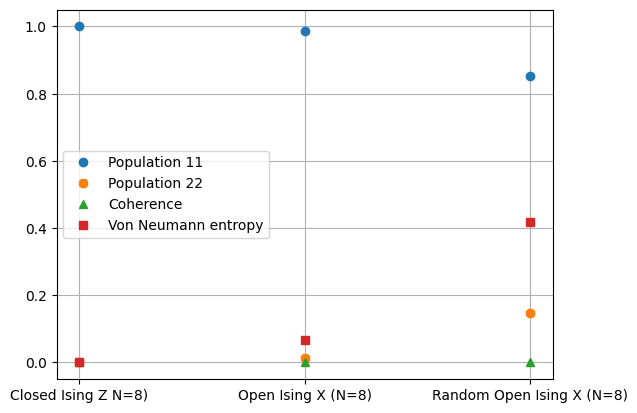

In [8]:
# Computing the density matrix, Von Neumann entropy, entanglement and disorder

models_2_3 = [CIz, OIx, ROIx]

x = []
y1 = []
y2 = []
y3 = []
y4 = []

for model in models_2_3:
    x.append(model.name)

    print_latex(r"\underline{\textbf{For " + model.name + r" mode}}")

    # Computing the ground state
    model.phi0, model.l0 = ground_state(model.H)

    # convert to 1D array 
    phi0 = np.asarray(model.phi0.T)[0] 
    
    # Computing the density matrix
    rho = avdensmat(phi0, model.N)
    print_latex(r"\rho = " + as_latex_matrix(rho))

    # Computing the Von Neumann entropy
    s = SvN(rho)
    print_latex(r"\text{Von Numann entropy: } S_{vN}(\rho) = " + f"{s:.3f}")

    # Computing the entanglement and disorder
    print_latex(r"\text{Entanglement: } \Epsilon(\phi_0, N) = " + f"{entangl(phi0, model.N):.3f}")
    print_latex(r"\text{Disorder: } D(\phi_0, N) = " + f"{disorder(phi0,model.N):.3f}")

    # Data to plot
    y1.append(rho[0,0])
    y2.append(rho[1,1])
    y3.append(np.abs(rho[0,1]))
    y4.append(s)

plt.plot(x, np.real(y1), "o", label="Population 11")
plt.plot(x, np.real(y2), "8", label="Population 22")
plt.plot(x, np.real(y3), "^", label="Coherence")
plt.plot(x, np.real(y4), "s", label="Von Neumann entropy")
plt.legend()
plt.grid()
plt.show()

We see that the closed ising Z model is the more stable one because all the population is on the ground state. From my interpretation, it seems logic because all the spins are aligned in the same direction so there is no concurrence between them, they are maintaining each other in the same state. In the open ising case, it's a bit less stable because the spins that are at the extremities of the chain can more easily change because they have only one neighbor to maintain them in the same state. In the random ising case, the spins are not aligned in the same direction so there is some concurrence between them and they can more easily change, which result in a greater population is the excited state and a greater entropy.

### 2.3.2 Antiferromagnetic systems

> **TP question:** Compute the ground states of a ferromagnetic Ising- $Z$ open chain of $N=8$ spins (with $w=0$., $J=1$. a.u.) and of an antiferromagnetic Ising-Z open chain of $N=8$ spins (with $w=0$., $J=-1$. a.u.). Compare the ground state of an antiferromagnetic material with the one of a ferromagnetic material. How are the spins organized in the two cases?

In [9]:
# Computing the ground state of ferro and antiferro Ising Z models with 8 spins

ferro_ising_Z_8 = Model("Open Ferromagnetic Ising Z", type=Model.openedIsing, N=8, w=0, J=[0,0,1])
antiferro_ising_Z_8 = Model("Open Antiferromagnetic Ising Z", type=Model.openedIsing, N=8, w=0, J=[0,0,-1])

# Computing the ground state
for model in [ferro_ising_Z_8, antiferro_ising_Z_8]:
    print_latex(r"\underline{\textbf{For " + model.name + r" model}}")
    print_latex(r"H = " + as_latex_matrix(model.H))
    model.phi0, model.l0 = ground_state(model.H)
    print_latex(r"\phi_0 = " + as_latex_matrix(model.phi0) + r"\quad \lambda_0 = " + f"{np.real(model.l0):.3f}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Converged in 692 iterations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Converged in 692 iterations


<IPython.core.display.Math object>

> **TP question:** Compute the ground states of a ferromagnetic Ising- $Z$ closed chain of $N=3$ spins (with $w=0$., $J=1$. a.u.) and of an antiferromagnetic Ising-Z closed chain of $N=3$ spins (with $w=0$., $J=-1$. a.u.). These chains can be interpreted as one cell of triangular lattices. Compare the ground states of these two spin triangles. What is the difference with the case of the open spin chains?

In [10]:
# Computing the ground state of ferro and antiferro Ising Z models with 3 spins

ferro_ising_Z_3 = Model("Closed Ferromagnetic Ising Z", type=Model.closedIsing, N=3, w=0, J=[0,0,1])
antiferro_ising_Z_3 = Model("Closed Antiferromagnetic Ising Z", type=Model.closedIsing, N=3, w=0, J=[0,0,-1])

# Computing the ground state
for model in [ferro_ising_Z_3, antiferro_ising_Z_3]:
    print_latex(r"\underline{\textbf{For " + model.name + r" model}}")
    print_latex(r"H = " + as_latex_matrix(model.H))
    model.phi0, model.l0 = ground_state(model.H)
    print_latex(r"\phi_0 = " + as_latex_matrix(model.phi0) + r"\quad \lambda_0 = " + f"{np.real(model.l0):.3f}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Converged in 42 iterations


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Converged in 121 iterations


<IPython.core.display.Math object>

> **TP question:** From your observations and/or personal research in the literature, explain this notion.

In the antiferromagnetic case, with 3 spins, we have a triangle of spins where the third one cannot be alligned with the two first ones. It result in a magnetic furstration which prevent to have a maximised mixed state.

--- 

# Chapter 3 - Dynamics of lattice spin systems

## 3.1 Studied models

> **TP question:** For each model, build with python the quantum Hamiltonian H as a $2^N \times 2^N$ array.

In [11]:
# Building models

Open_HeisenbergXXX_7 = Model("Open Heisenberg XXX", type=Model.openedHeisenberg, N=7, J=0.1, w=1)
Closed_HeisenbergXXX_7 = Model("Closed Heisenberg XXX", type=Model.closedHeisenberg, N=7, J=0.1, w=1)
Inhomogeneous_HeisenbergXXX_7 = Model("Inhomogeneous Heisenberg XXX", type=Model.inhomoHeisenberg, N=7, w=1)

models_3_1 = [Open_HeisenbergXXX_7, Closed_HeisenbergXXX_7, Inhomogeneous_HeisenbergXXX_7]

for model in models_3_1:
    print_latex(r"\underline{\textbf{For " + model.name + r" model}}")
    print_latex(as_latex_matrix(model.H))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 3.2 Spectral integrator

> **TP question:** Define a python function corresponding to the spectral integrator with the following requirement:
>
> `def Dyn(H,t,psi0)`
>    - input data
>        - `H`: 2D array corresponding to the quantum Hamiltonian represented in any basis, or 1D array corresponding to the diagonal of the quantum Hamiltonian in its eigenbasis.
>         - `t`: duration of the time propagation (real number).
>        - `psi0`: 1D array corresponding to the initial quantum state represented in the same basis than H.
>    - output\
>        - 1D array corresponding to |ψ(t)〉 = U (t, 0)|ψ0〉 represente in the same basis than H.

In [12]:
# Dynamics of a system

def Dyn(H,t,psi0):
    return LA2.expm(-1j*H*t) @ psi0

## 3.3 Dynamics

> **TP question:** For each model (1) to (3) of Sec $3.1$ integrate the Schrödinger equation on the time interval $t \in[0,500]$ a.u. and compute a list of lists:
> $$
> \text { pop }=\left[\left[\left(\rho_k(i \Delta t)\right)_{11} \text { for } k \in\{1,7\}\right] \text { for } i \in\left\{0, N_{\text {time }}\right\}\right],
> $$
> where $N_{\text {time }}=200$ and $\Delta t=\frac{T}{N_{\text {time }}} \cdot \rho_k(t)$ is the reduced density matrix of the $k$-th spin at time $t$, and then $\left(\rho_k(t)\right)_{11}$ is the population of the state $|1\rangle$ for the $k$-th spin at time $t$.
> For each model and for the two above initial conditions plot a density graph of the population of the state $|1\rangle$ with respect to the spins of the chain (abscissae) and to the time (ordinates), with a color gradient associated with the occupation probability of $|1\rangle$ (in $[0,1])$.

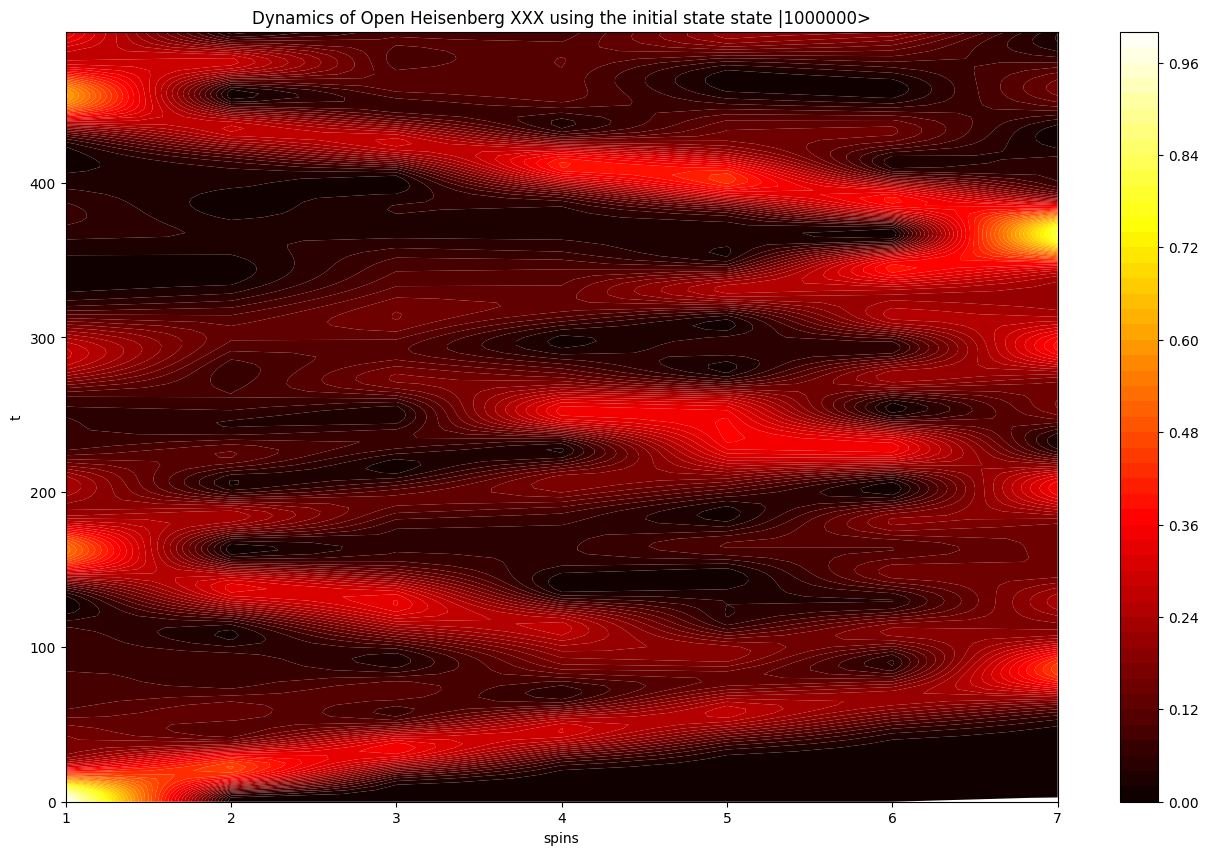

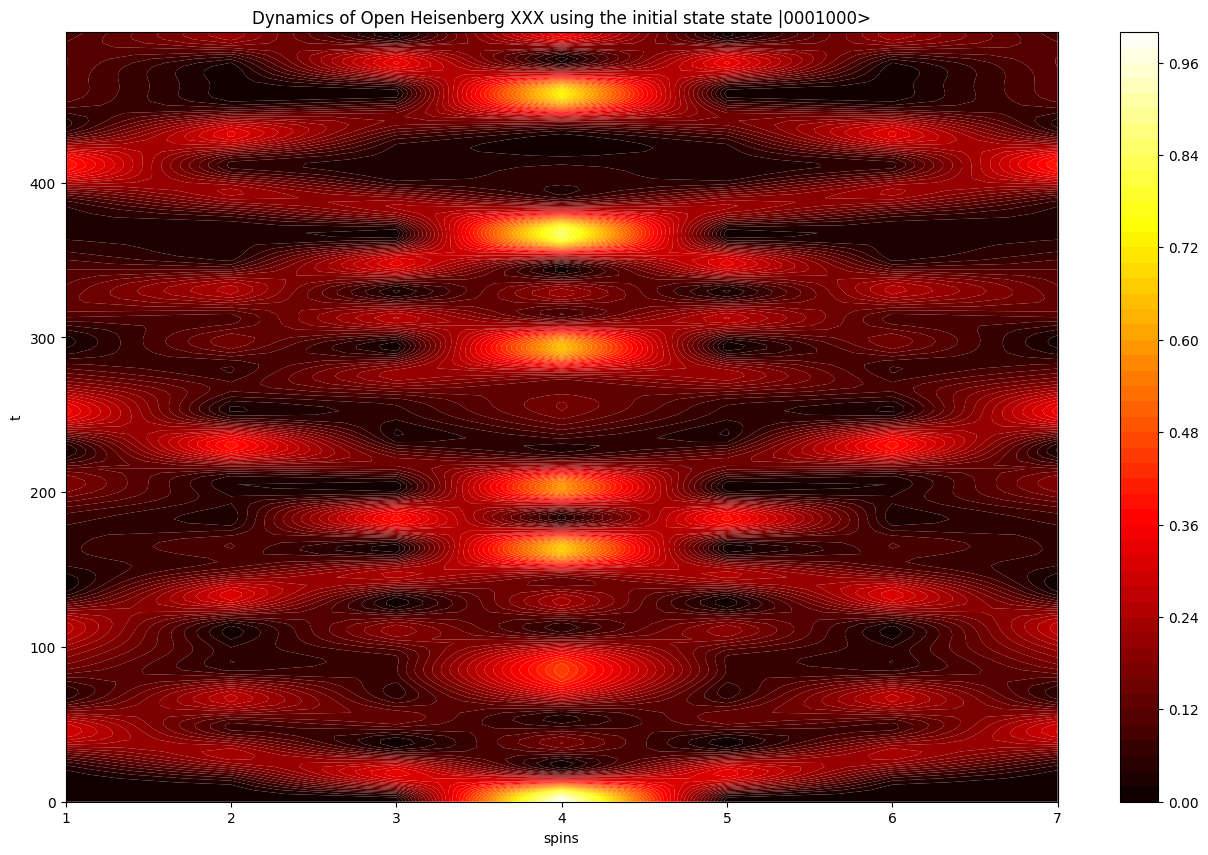

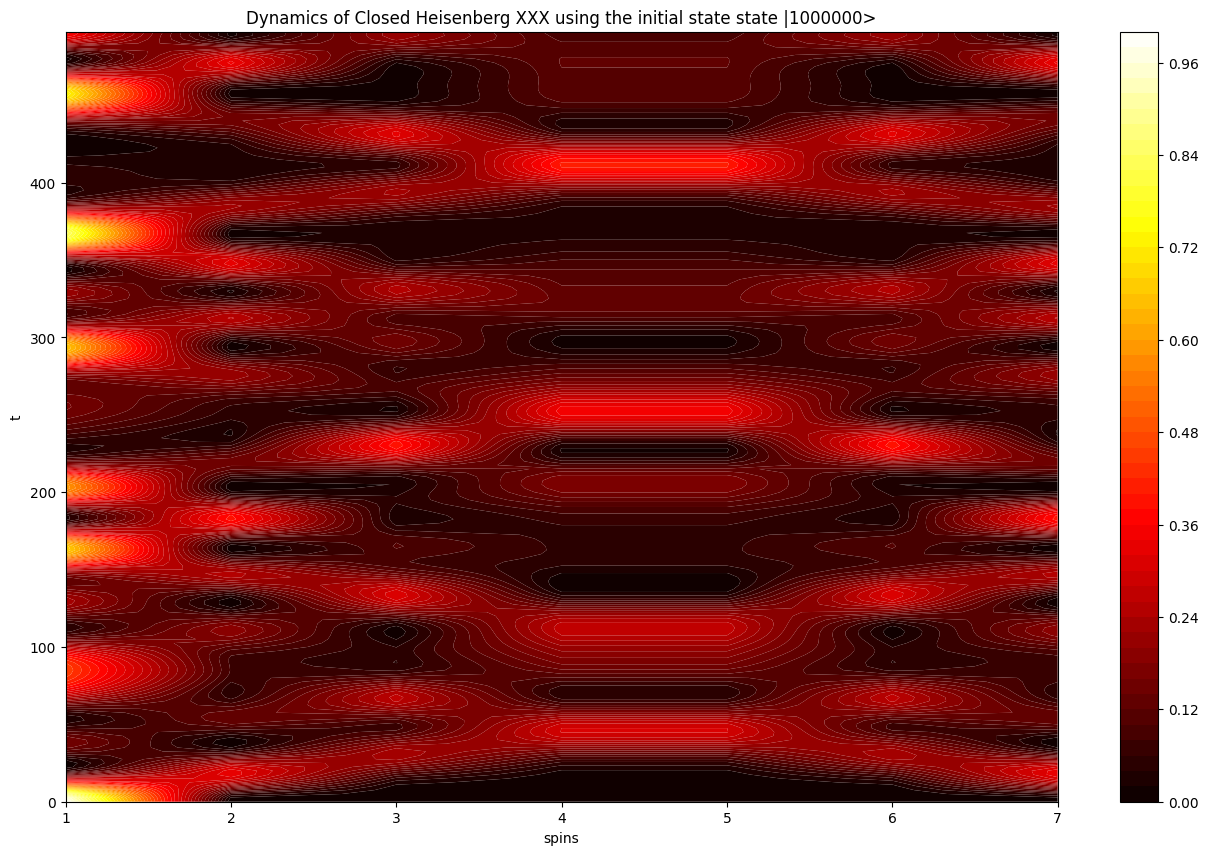

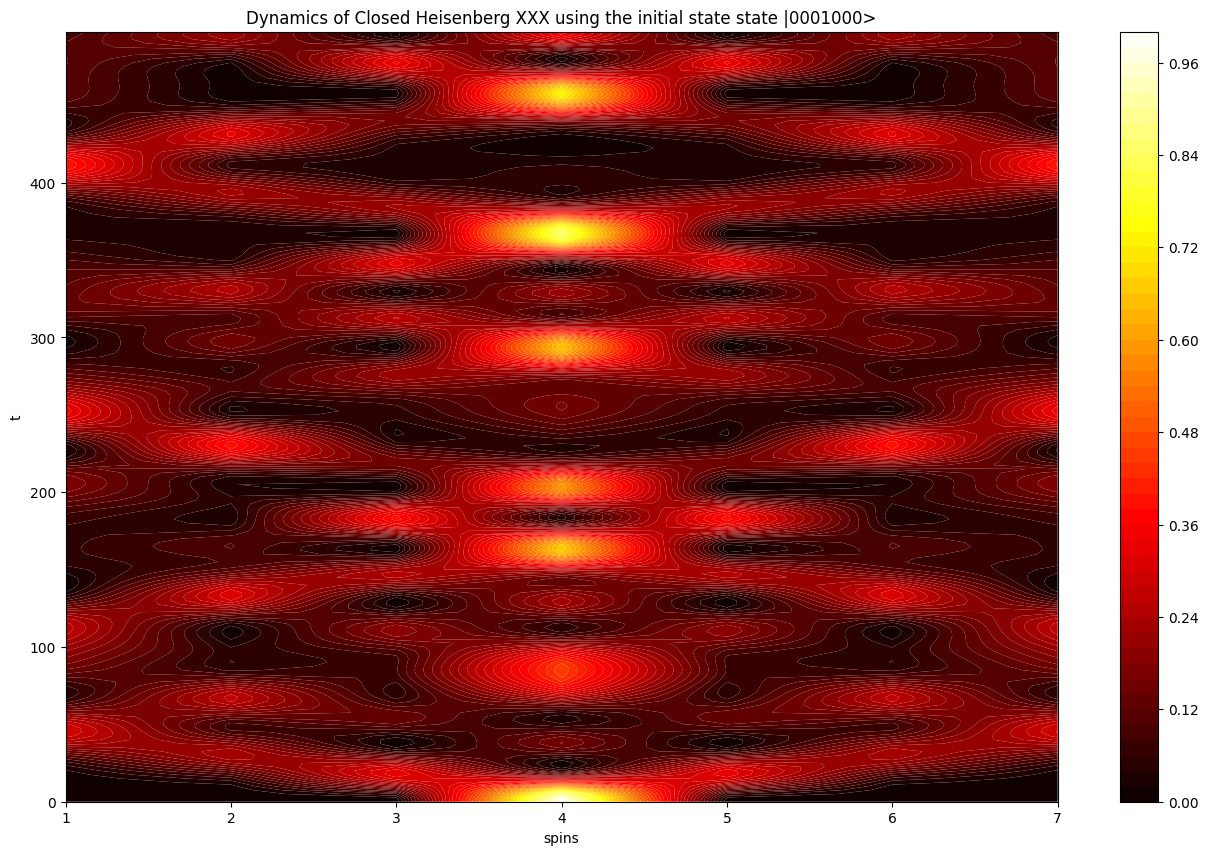

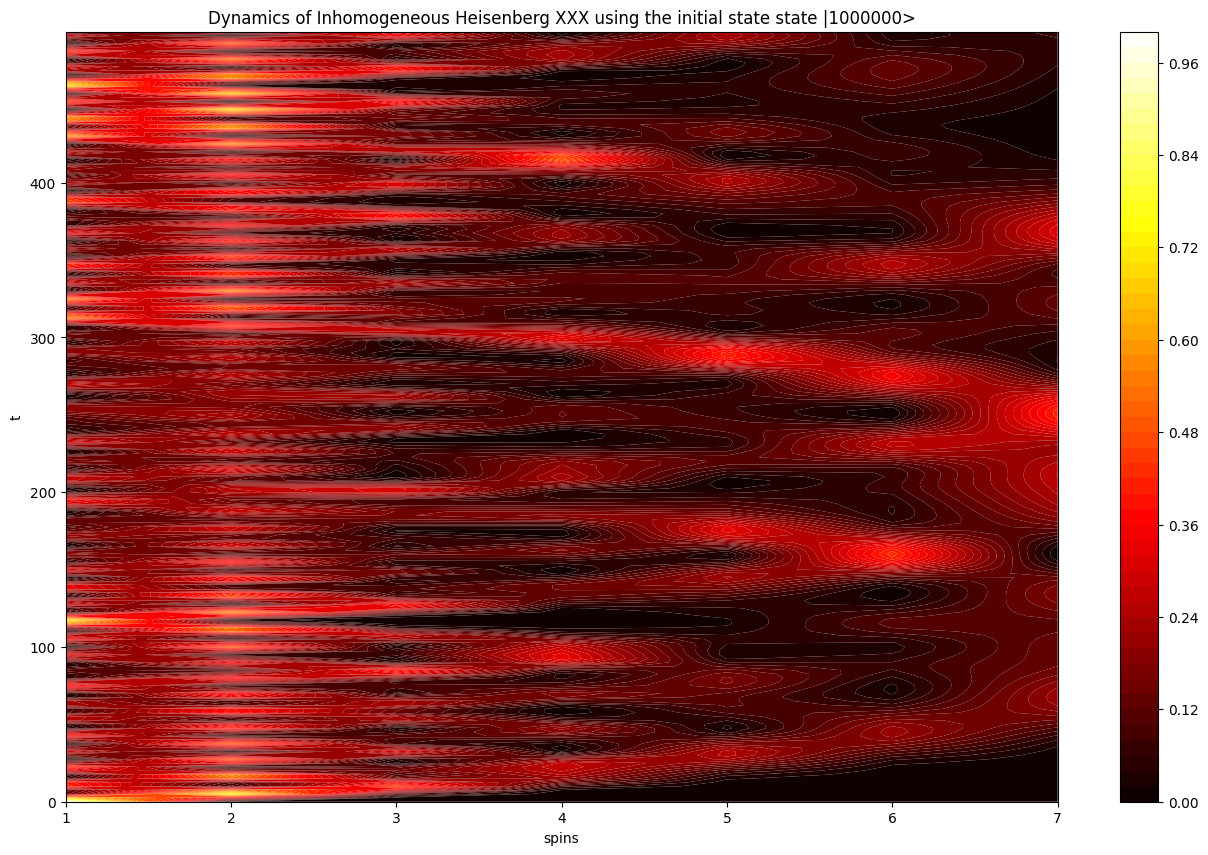

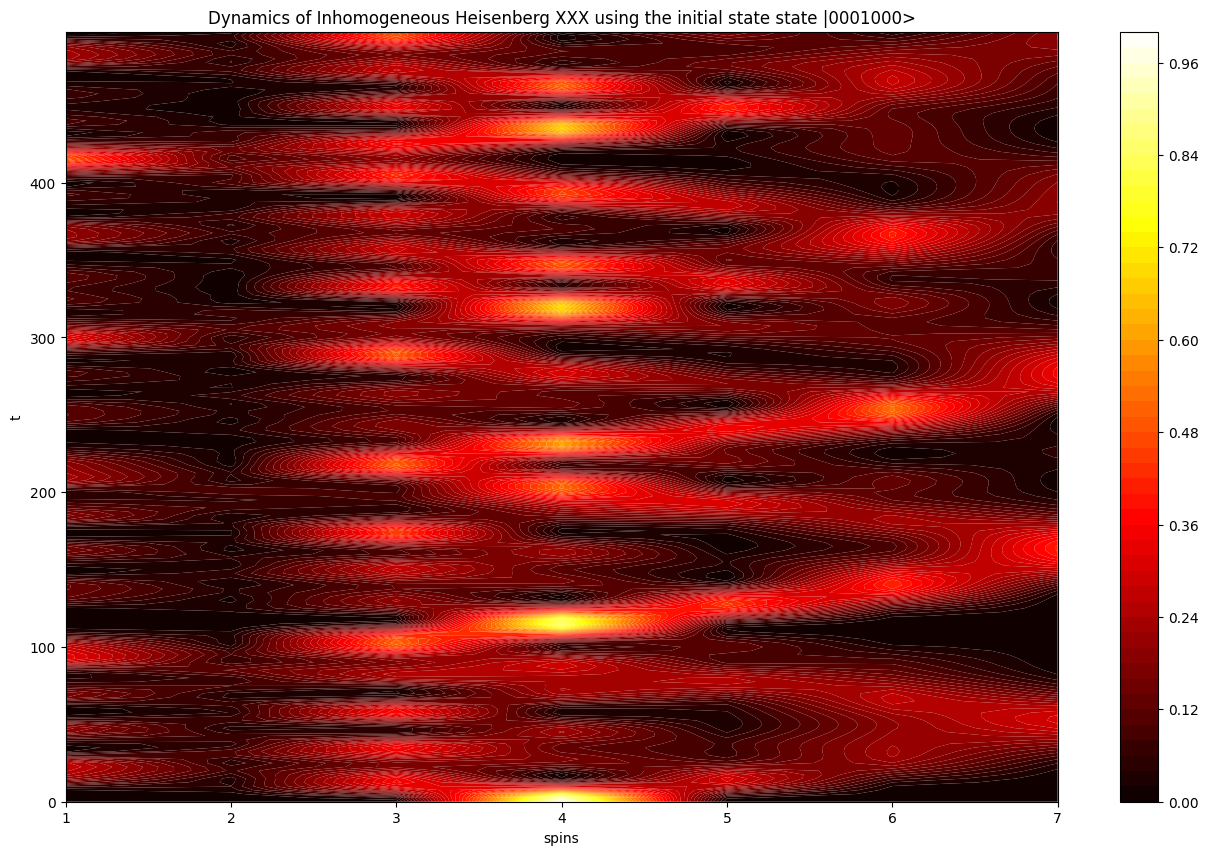

In [15]:
def plot_dynamics(model, T, state):
    N_time = 200
    dt = T / N_time
    psi0 = np.matrix(buildstate(state)).T # convert the string into a column vector
    pop = np.empty((model.N, N_time))
    for i in range(N_time):
        for k in range(model.N):
            psi = Dyn(model.H, i * dt, psi0)
            pop[k, i] = np.real(densmat(psi, k + 1, model.N))[0, 0]
    
    pop = -pop + 1

    plt.figure(figsize=(16, 10))
    plt.contourf(range(1, model.N + 1), [i * dt for i in range(N_time)], pop.T, [i*0.02 for i in range(51)], cmap="hot", antialiased=True)
    plt.xlabel("spins")
    plt.ylabel("t")
    plt.title("Dynamics of " + model.name + " using the initial state state |" + state + ">")
    plt.colorbar()
    plt.show()

for model in models_3_1:
    plot_dynamics(model, 500, '1000000')
    plot_dynamics(model, 500, '0001000')
    

> **TP question:** Comment the graphs. Explain the behaviours of the quantum excitation. What is the important difference between open and closed chains? For the model (1) let vary $w$ and J (using also smaller and larger values than the ones used before), to establish how the propagation of a quantum excitation in the spin chain depends on the Larmor frequency and the exchange integral (study in particular the propagation speed of the quantum excitation).

### Open Heisenberg XXX model

Using the initial state state $\ket{1000000}$, we see a propagation of the state $\ket 1$ from left to right, then bouce at the extremities of the chain.

Using the initial state state $\ket{0001000}$, the overhaul system is symetric, so as expected, the state $\ket 1$ is propagating from left to right and from right to left in a symetrical way.

### Closed Heisenberg XXX model

Using the initial state state $\ket{1000000}$, we see a propagation of the state $\ket 1$ from left to right as before, but also from right to left, jumping from the first to the last spin because they are now neighbors.

Using the initial state state $\ket{0001000}$, we get back to a symetrical propagation which is identical to the open case. My interpretation is that the reflexion at the extremities of the open chain is the same as the transmission from a spin to another, like a Bragg reflexion.

### Inhomogeneous Heisenberg XXX model

Using the initial state state $\ket{1000000}$, we see that the propagation of the state $\ket 1$ is more difficult, it mostly stay on the left side, but can't stay on it for long. On the other hand, there is somme states where a spin can keep the state $\ket 1$ longer, linke the spin 7 at t=250.

Using the initial state state $\ket{0001000}$, we recognize similar chapes as in the previous cases, but the system is no more symetrical. The most remarkable thing is that some spins are more likely to be in the state $\ket 1$ than others. The spin 7 is the most likely to be in the state $\ket 1$ and the spin 2 seems almost always in the state $\ket 0$.